In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import einops

from glob import glob
import functools
import json
import os
import re

sns.set_theme(style="darkgrid", context="notebook", palette=sns.color_palette("rocket", 4))
matplotlib.rcParams['figure.figsize'] = (20, 10)

%matplotlib inline

In [2]:
# load all results
results_dirs = sorted(glob(f"results/*"))
results_arrays = {file: np.load(file) for file in glob(f"results/**/*.npz", recursive=True)}
all_results = []
directions = {}
for dir in results_dirs:
    # read json
    file = os.path.join(dir, "metrics.json")
    with open(file) as f:
        results = json.load(f)
    # extract the model name from the filename
    model = re.search(r"results/(.*)/?", dir).group(1)
    directions[model] = np.stack([
        results_arrays[results.pop(direction)][direction]
        for direction in ["yes", "no"]
    ])
    # save layers without breaking df
    for task_name, problem in results.items():
        # add the data to the results (to be turned into df)
        all_results.append({
            "task": task_name,
            "model": model,
            "task/model": f"{task_name}/{model}",
            } | {
                # keep attributes as arrays
                problem_name: array
                for problem_name, array in problem.items()
            }
        )
df = pd.DataFrame(all_results)
df.head()

,task,model,task/model,truth,path
0,boolq,Llama-2-7b-hf,boolq/Llama-2-7b-hf,results/Llama-2-7b-hf/boolq/data.npz,results/Llama-2-7b-hf/boolq/data.npz
1,boolq,gpt2-xl,boolq/gpt2-xl,results/gpt2-xl/boolq/data.npz,results/gpt2-xl/boolq/data.npz
2,boolq,pythia-6.9b,boolq/pythia-6.9b,results/pythia-6.9b/boolq/data.npz,results/pythia-6.9b/boolq/data.npz


In [3]:
# generic compose function
compose = lambda *F: functools.reduce(lambda f, g: lambda x: f(g(x)), F)

In [4]:
def plot_path(results: pd.DataFrame, title: str, key: str = "path", split_key="task/model", transform=None):
    splits = results[split_key].unique()
    fig, axes = plt.subplots(len(splits))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    data = []
    for split in splits:
        results_filename = results.loc[results[split_key] == split].iloc[0].loc[key]
        model = results.loc[results[split_key] == split].iloc[0].loc["model"]
        path = results_arrays[results_filename][key]
        truths = results_arrays[results_filename]["truth"]
        flattened_path, shape = einops.pack(path, "* h")
        logits = einops.einsum(flattened_path, directions[model], "n h, d h -> n d")
        logits -= logits.max(-1, keepdims=True)
        probabilities = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
        probability = probabilities[:, 0]
        path = einops.unpack(probability, shape, "*")
        for i, sample in enumerate(path):
            for j, layer in enumerate(sample):
                data.append({
                    "split": split,
                    "layer": j,
                    "x": layer,
                    "sample": i,
                    "truth": truths[i],
                })

    # convert results to a dataframe
    data = pd.DataFrame(data)

    # plot results on each axis
    for i, split in enumerate(splits):
        ax = axes[i] if len(splits) > 1 else axes
        # plot a line
        sns.lineplot(data=data[data["split"] == split], x="layer", y="x", hue="truth", ax=ax, style="truth", legend=i == 0)
        handles, labels = ax.get_legend_handles_labels()
        if i == 0:
            plt.legend(handles=handles[-3:], labels=labels[-3:])
        # perform a transform to the axis
        if transform is not None:
            transform(ax)
        ax.set_title(split)
        ax.set_xlabel("")
    plt.suptitle(title)


In [5]:
def draw_horizontal_line(ax: plt.Axes, y: float) -> plt.Axes:
    """draw of horizontal line of a given height"""
    ax.axhline(y=y, color=sns.color_palette()[-1], linestyle="--", linewidth=1)
    return ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


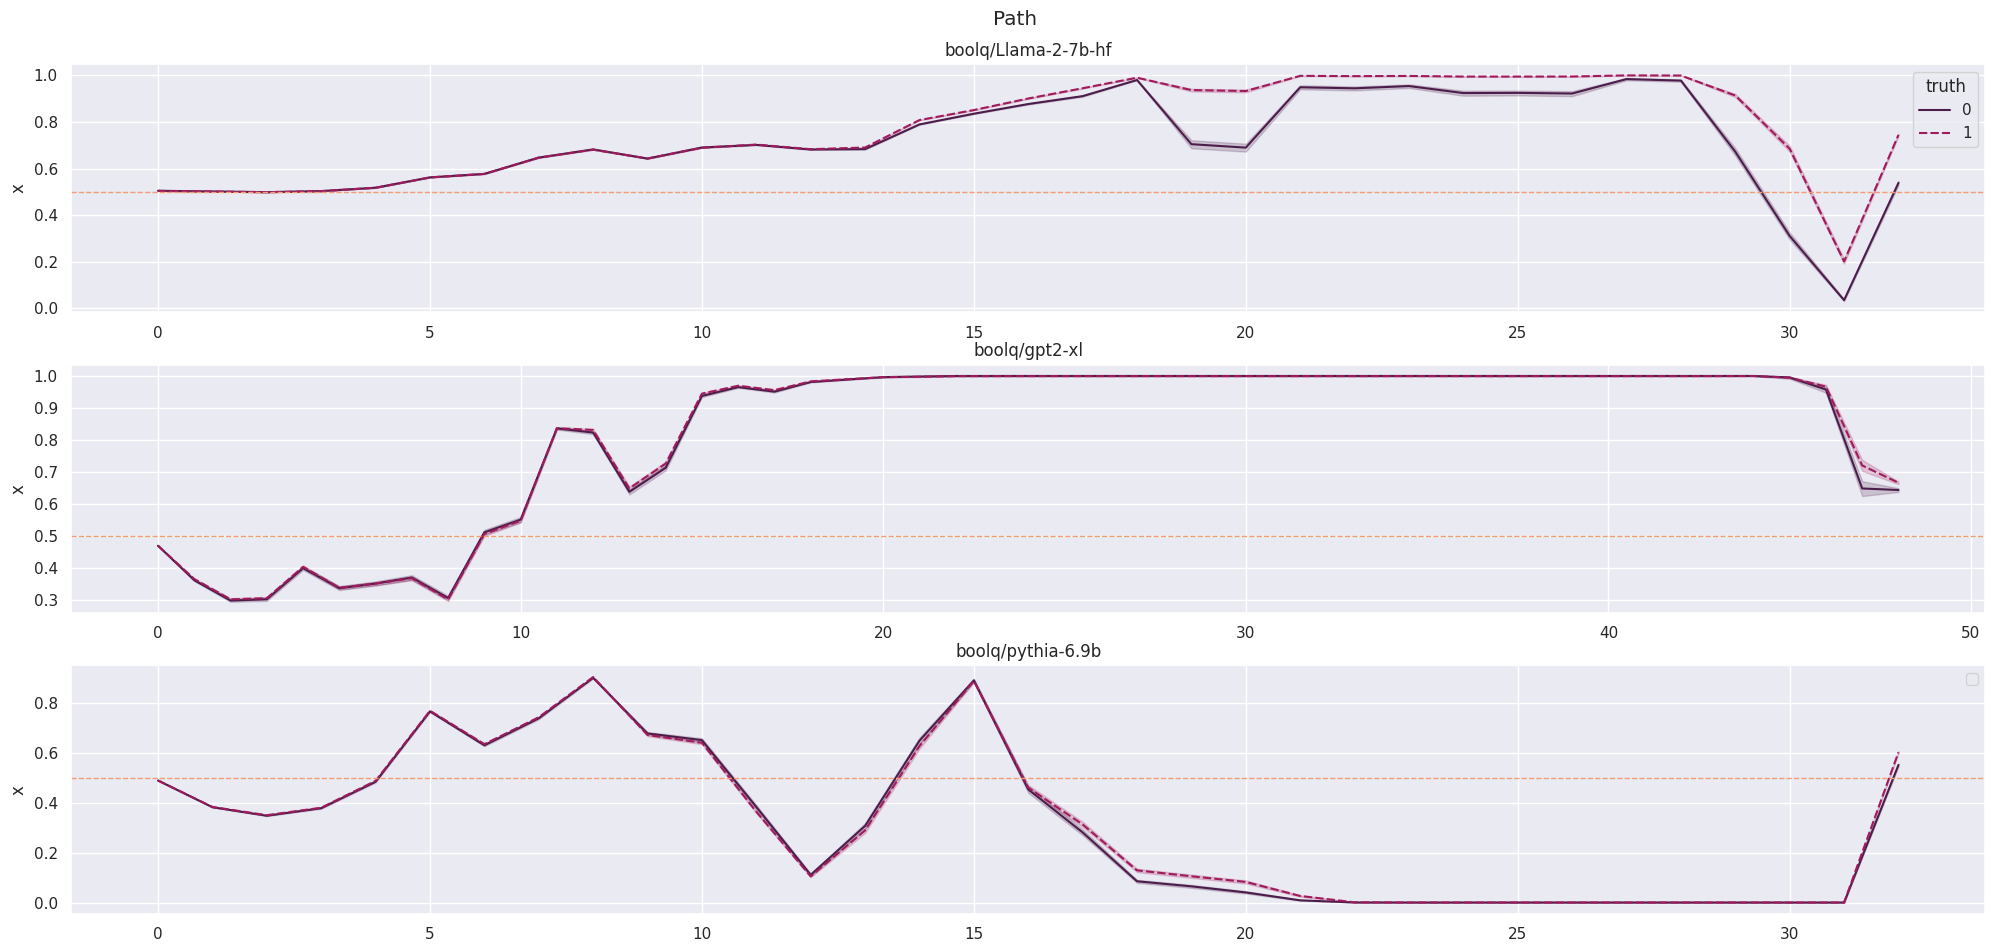

In [6]:
plot_path(df, "Path", transform=functools.partial(draw_horizontal_line, y=0.5))